Error: Some geometries are not LineString or MultiLineString.
2.2379242063857236
297.22425426946097
-----
3.3080854310748604
270.54884974462345
-----
0.609598838247308
691.6578048580479
-----
0.6202984703287979
164.40596831766513
-----
2.6492402930536048
56.84856090190817
-----
2.4633769238923873
402.41363393568906
-----
1.179282278337936
604.5689206439287
-----
0.14264939485819042
628.7013940463329
-----
1.087434534704035
80.894786989832
-----
4.957552872108018
114.08805923026706
-----
2.851090343449809
72.46065728230171
-----
6.438720909994169
145.09663365450308
-----
Selected Locations: ['BiscayneBay_S123_T', 'S155_T_LakeWorthLagoon', 'Settlement_Point', 'Port_Canaveral_FL', 'Bings_Landing', 'Fernandina_Beach', 'St_Simons_Island', 'Fripps_Inlet', 'South_Capers_Island', 'Sunset_Beach', 'Wilmington_NC', 'Beaufort']
Locations: {'BiscayneBay_S123_T': {'latitude': 25.61055556, 'longitude': -80.3075}, 'S155_T_LakeWorthLagoon': {'latitude': 26.64472222, 'longitude': -80.05472222}, 'Settlem

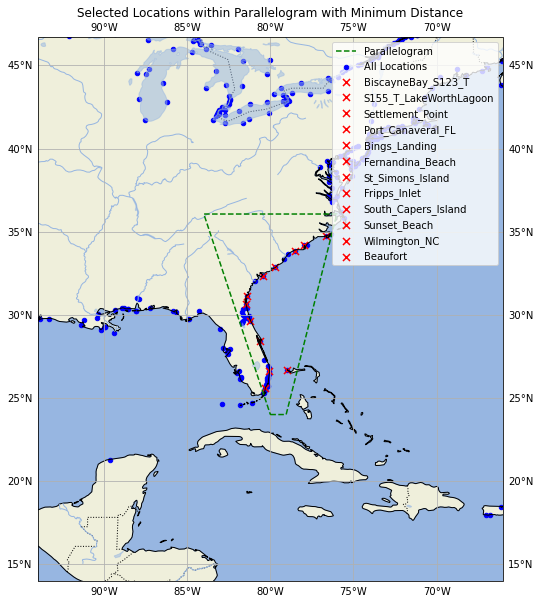

In [27]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
from matplotlib.path import Path
import math
from shapely.geometry import Point, LineString, MultiLineString

# Function to calculate distance using the Haversine formula
def haversine(lon1, lat1, lon2, lat2):
    # Convert latitude and longitude from degrees to radians
    lon1, lat1, lon2, lat2 = map(math.radians, [lon1, lat1, lon2, lat2])

    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    r = 6371  # Radius of Earth in kilometers
    distance = r * c
    return distance

# Function to check if points are inside a polygon
def points_in_polygon(points, polygon):
    path = Path(polygon)
    return path.contains_points(points)

# Function to filter points to ensure a minimum distance between them
def filter_by_distance(coords, min_distance_km):
    filtered_coords = []
    for coord in coords:
        if all(haversine(coord['longitude'], coord['latitude'], fc['longitude'], fc['latitude']) >= min_distance_km for fc in filtered_coords):
            filtered_coords.append(coord)
    return filtered_coords

# Function to calculate distance from coastline
def distance_from_coastline(lon, lat, coastline):
    point = Point(lon, lat)
    min_distance = float('inf')
    for geom in coastline:
        if isinstance(geom, (LineString, MultiLineString)):
            if isinstance(geom, LineString):
                distance = geom.distance(point) * 111  # Convert degrees to kilometers
            else:  # MultiLineString
                distance = min(line.distance(point) for line in geom.geoms) * 111  # Convert degrees to kilometers
            if distance < min_distance:
                min_distance = distance
    return min_distance

# Choose the region
region = 'EAST_AUSTRALIA'


# # # EAST_AUSTRALIA
# # parallelogram_vertices = np.array([
# #     [149, -38],  # Bottom-left
# #     [158, -38],  # Bottom-right
# #     [158, -25],  # Top-right
# #     [149, -25]   # Top-left
# # ])

# # # NORWAY
# # parallelogram_vertices = np.array([
# #     [5, 58],  # Bottom-left
# #     [7, 58],  # Bottom-right
# #     [20, 70],  # Top-right
# #     [5, 70]   # Top-left
# # ])

# # # NORTH_WEST_AMERICA
# # parallelogram_vertices = np.array([
# #     [-119, 32],  # Bottom-left
# #     [-116, 32],  # Bottom-right
# #     [-123, 47],  # Top-right
# #     [-127, 47]   # Top-left
# # ])

# NORTH_EAST_AMERICA
# parallelogram_vertices = np.array([
#     [-80, 24],  # Bottom-left
#     [-79.05, 26.2],  # Bottom-right
#     [-74, 47],  # Top-right
#     [-84, 36.06]   # Top-left
# ])


# Define the vertices of the parallelogram for NORTH_WEST_AMERICA
parallelogram_vertices = np.array([
    [-80, 24],  # Bottom-left
    [-79.05, 24],  # Bottom-right
    [-76, 36.06],  # Top-right
    [-84, 36.06]   # Top-left
])


# Load the dataset
file_path = '/DGFI8/H/work_marcello/machine_learning_altimetry_validation/gesla_2004_selected_lowess_dac_correctedglobal.nc'
#file_path = '/DGFI8/H/work_marcello/machine_learning_altimetry_validation/gesla_2023_selected_lowess_dac_correctedaustralia.nc'

ds = xr.open_dataset(file_path)

# Extract the relevant variables
latitudes = ds['latitude'].values
longitudes = ds['longitude'].values
site_names = ds['site_name'].values

# Combine latitudes and longitudes into a single array of points
points = np.vstack((longitudes, latitudes)).T

# Filter locations based on the parallelogram
selected_indices = points_in_polygon(points, parallelogram_vertices)

selected_sites = site_names[selected_indices]
selected_coords = [{
    'site_name': site_name,
    'latitude': latitudes[i],
    'longitude': longitudes[i]
} for i, site_name in enumerate(site_names) if selected_indices[i]]

# Filter the selected coordinates to ensure a minimum distance of 50 km
min_distance_km = 50
filtered_coords = filter_by_distance(selected_coords, min_distance_km)

# Load coastline data
coastline = list(cfeature.COASTLINE.geometries())
rivers = list(cfeature.RIVERS.geometries())

# Check if all geometries are valid
if not all(isinstance(geom, (LineString, MultiLineString)) for geom in coastline + rivers):
    print("Error: Some geometries are not LineString or MultiLineString.")

# Function to calculate distance from rivers
def distance_from_river(lon, lat, rivers):
    point = Point(lon, lat)
    min_distance = float('inf')
    for geom in rivers:
        if isinstance(geom, (LineString, MultiLineString)):
            if isinstance(geom, LineString):
                distance = geom.distance(point) * 111  # Convert degrees to kilometers
            else:  # MultiLineString
                distance = min(line.distance(point) for line in geom.geoms) * 111  # Convert degrees to kilometers
            if distance < min_distance:
                min_distance = distance
    return min_distance

# Filter coordinates based on proximity to coastline (within 10 km) and not near river mouths (more than 1 km)
max_distance_km = 10
min_river_distance_km = 25
final_coords = []
for coord in filtered_coords:
    distance_to_coastline = distance_from_coastline(coord['longitude'], coord['latitude'], coastline)
    distance_to_river = distance_from_river(coord['longitude'], coord['latitude'], rivers)
    if distance_to_coastline <= max_distance_km and distance_to_river > min_river_distance_km:
        print(distance_to_coastline)
        print(distance_to_river)
        print('-----')
        final_coords.append(coord)

# Sort the final coordinates from south to north
final_coords_sorted = sorted(final_coords, key=lambda x: x['latitude'])

# Extract sorted site names and coordinates
selected_locations = [coord['site_name'] for coord in final_coords_sorted]
locations = {coord['site_name']: {'latitude': coord['latitude'], 'longitude': coord['longitude']} for coord in final_coords_sorted}

# Print selected locations and their coordinates
print("Selected Locations:", selected_locations)
print("Locations:", locations)

# Plot the map
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([np.min(parallelogram_vertices[:, 0]) - 10, np.max(parallelogram_vertices[:, 0]) + 10,
               np.min(parallelogram_vertices[:, 1]) - 10, np.max(parallelogram_vertices[:, 1]) + 10])

# Add geographic features
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.RIVERS)

# Plot all locations
ax.scatter(longitudes, latitudes, color='blue', marker='o', s=20, transform=ccrs.PlateCarree(), label='All Locations')

# Highlight selected locations
for site_name in selected_locations:
    coord = locations[site_name]
    ax.scatter(coord['longitude'], coord['latitude'], color='red', marker='x', s=50, transform=ccrs.PlateCarree(), label=site_name)

# Plot the parallelogram
parallelogram_path = np.vstack((parallelogram_vertices, parallelogram_vertices[0]))
ax.plot(parallelogram_path[:, 0], parallelogram_path[:, 1], color='green', linestyle='--', transform=ccrs.PlateCarree(), label='Parallelogram')

# Add legend
ax.legend(loc='upper right')

# Add gridlines
ax.gridlines(draw_labels=True)

plt.title('Selected Locations within Parallelogram with Minimum Distance')
plt.show()



Shape of filtered_sla_dac_filtered: (366, 12)
Number of valid site names: 12


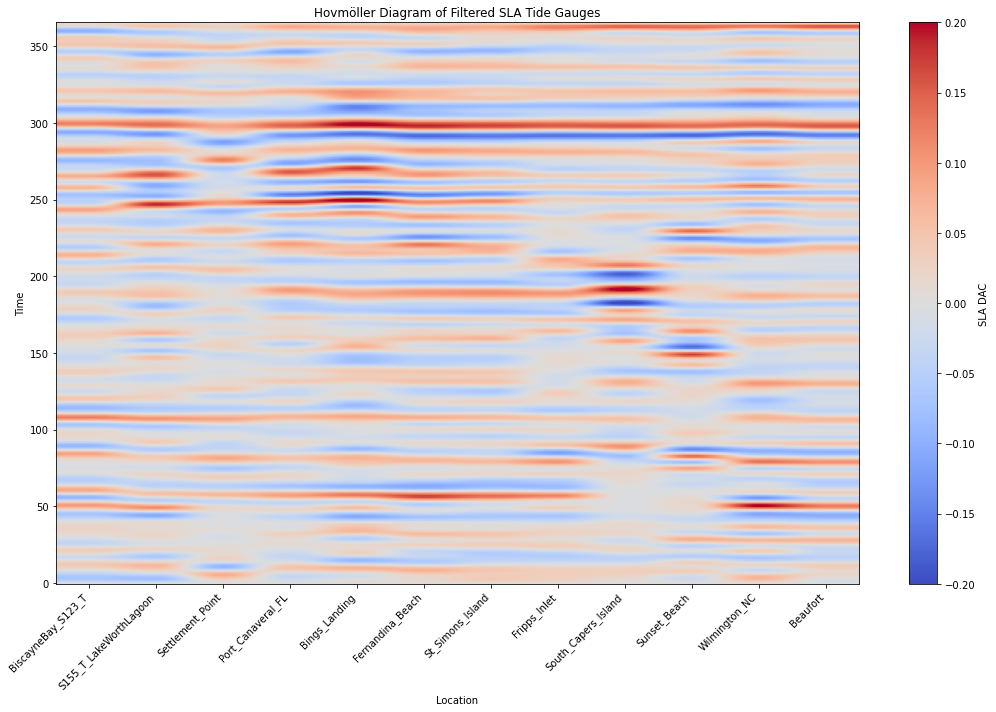

Latitude and Longitude for Selected Locations:
BiscayneBay_S123_T: Latitude 25.61055556, Longitude -80.3075
S155_T_LakeWorthLagoon: Latitude 26.64472222, Longitude -80.05472222
Settlement_Point: Latitude 26.69, Longitude -78.983
Port_Canaveral_FL: Latitude 28.415, Longitude -80.593
Bings_Landing: Latitude 29.615, Longitude -81.205
Fernandina_Beach: Latitude 30.672, Longitude -81.467
St_Simons_Island: Latitude 31.1317, Longitude -81.3967
Fripps_Inlet: Latitude 32.34, Longitude -80.465
South_Capers_Island: Latitude 32.8567, Longitude -79.7067
Sunset_Beach: Latitude 33.865, Longitude -78.5067
Wilmington_NC: Latitude 34.227, Longitude -77.953
Beaufort: Latitude 34.72, Longitude -76.67


In [28]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import Normalize
from scipy.signal import butter, filtfilt
from fuzzywuzzy import process

# Load the dataset
dataset = xr.open_dataset(file_path)

# Convert hourly data to daily means
daily_dataset = dataset.resample(date_time='D').mean()

# Extract necessary variables
sla_dac = daily_dataset['sla_dac'].values
time = daily_dataset['date_time'].values
site_names = dataset['site_name'].values
latitudes = dataset['latitude'].values
longitudes = dataset['longitude'].values

# Define the Butterworth bandpass filter
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data, axis=0)
    return y

def interpolate_nan(data):
    """Interpolate NaNs in the data."""
    nans, x = np.isnan(data), lambda z: z.nonzero()[0]
    data[nans] = np.interp(x(nans), x(~nans), data[~nans])
    return data



# Frequency cutoffs in cycles per day
lowcut = 0.035
highcut = 0.15
fs = 1.0  # Sampling frequency in cycles per day



# Find closest matches for selected locations in the dataset's site_names
filtered_indices = []
valid_site_names = []
valid_latitudes = []
valid_longitudes = []

for loc in selected_locations:
    match = process.extractOne(loc, site_names)
    if match[1] >= 80:  # Minimum similarity score threshold
        idx = np.where(site_names == match[0])[0][0]
        filtered_indices.append(idx)
        valid_site_names.append(match[0])
        valid_latitudes.append(latitudes[idx])
        valid_longitudes.append(longitudes[idx])
    else:
        print(f"No close match found for '{loc}'.")

# Filter sla_dac and reorder according to filtered indices
filtered_sla_dac = sla_dac[:, filtered_indices]

# Calculate the mean of each row
row_means = np.nanmean(filtered_sla_dac, axis=0)

# Subtract the row mean from each element in the row
filtered_sla_dac_demeaned = filtered_sla_dac - row_means[np.newaxis,:]

# Apply the Butterworth bandpass filter to each time series
filtered_sla_dac_filtered = []
for i in range(filtered_sla_dac.shape[1]):
    series = filtered_sla_dac[:, i]
    nan_count = np.isnan(series).sum()
    if nan_count <= 0.9 * len(time):  # Keep if less than or equal to 90% NaNs
        if nan_count > 0:
            series = interpolate_nan(series)
        series = butter_bandpass_filter(series, lowcut, highcut, fs, order=5)
        filtered_sla_dac_filtered.append(series)

filtered_sla_dac_filtered = np.array(filtered_sla_dac_filtered).T  # Transpose for correct shape

# Check the shapes of the data arrays
print("Shape of filtered_sla_dac_filtered:", filtered_sla_dac_filtered.shape)
print("Number of valid site names:", len(valid_site_names))

# Create the Hovmöller diagram using imshow with masked array
fig, ax = plt.subplots(figsize=(15, 10))

# Set normalization for the color scale
norm = Normalize(vmin=-0.2, vmax=0.2)

# Plot using imshow with masked array
im = ax.imshow(filtered_sla_dac_filtered, aspect='auto', cmap='coolwarm', origin='lower', norm=norm)

# Set labels and title
ax.set_xlabel('Location')
ax.set_ylabel('Time')
ax.set_title('Hovmöller Diagram of Filtered SLA Tide Gauges')

# Add colorbar
cbar = fig.colorbar(im, ax=ax)
cbar.set_label('SLA DAC')

# Set x-axis ticks and labels (locations)
ax.set_xticks(np.arange(len(valid_site_names)))
ax.set_xticklabels(valid_site_names, rotation=45, ha="right")

plt.tight_layout()
plt.show()

# Print latitude and longitude for each selected location
print("Latitude and Longitude for Selected Locations:")
for name, lat, lon in zip(valid_site_names, valid_latitudes, valid_longitudes):
    print(f"{name}: Latitude {lat}, Longitude {lon}")


# Extract CMEMS GRIDS

Open with xarray an example file of the dataset located in /DGFI8/H/work_marcello/giussani_machinelearning_data/SEALEVEL_GLO_PHY_L4_REP_OBSERVATIONS_008_047/2004, which is divided in subfolders from 01 to 12 corresponding to the months, and each subfolder contain daily gridded sea level data in files like this one: dt_global_allsat_phy_l4_20040211_20210726.nc


Dataset Information:
<xarray.Dataset>
Dimensions:         (latitude: 720, longitude: 1440, nv: 2, time: 1)
Coordinates:
  * time            (time) datetime64[ns] 2004-01-26
  * latitude        (latitude) float32 -89.88 -89.62 -89.38 ... 89.62 89.88
  * longitude       (longitude) float32 -179.9 -179.6 -179.4 ... 179.6 179.9
  * nv              (nv) int32 0 1
Data variables: (12/14)
    crs             int32 ...
    lat_bnds        (latitude, nv) float32 ...
    lon_bnds        (longitude, nv) float32 ...
    sla             (time, latitude, longitude) float64 ...
    err_sla         (time, latitude, longitude) float64 ...
    ugosa           (time, latitude, longitude) float64 ...
    ...              ...
    err_vgosa       (time, latitude, longitude) float64 ...
    adt             (time, latitude, longitude) float64 ...
    ugos            (time, latitude, longitude) float64 ...
    vgos            (time, latitude, longitude) float64 ...
    flag_ice        (time, latitude, longitude) float64 ...
    tpa_correction  (time) float64 ...
Attributes: (12/44)
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Grid
    comment:                         Sea Surface Height measured by Altimetry...
    contact:                         servicedesk.cmems@mercator-ocean.eu
    creator_email:                   servicedesk.cmems@mercator-ocean.eu
    ...                              ...
    summary:                         SSALTO/DUACS Delayed-Time Level-4 sea su...
    time_coverage_duration:          P1D
    time_coverage_end:               2004-01-26T12:00:00Z
    time_coverage_resolution:        P1D
    time_coverage_start:             2004-01-25T12:00:00Z
    title:                           DT merged all satellites Global Ocean Gr...



I will give you now the structure of each file

Extract from a random latitude longitude point a complete time series of the variable "sla"

I will show you now the dataset information. From this dataset, you have to create one similar to the one contained in filtered_sla_dac_filtered, so that for each location identified in filtered_sla_dac_filtered you find the closest point in this new dataset extracting the field "sla"

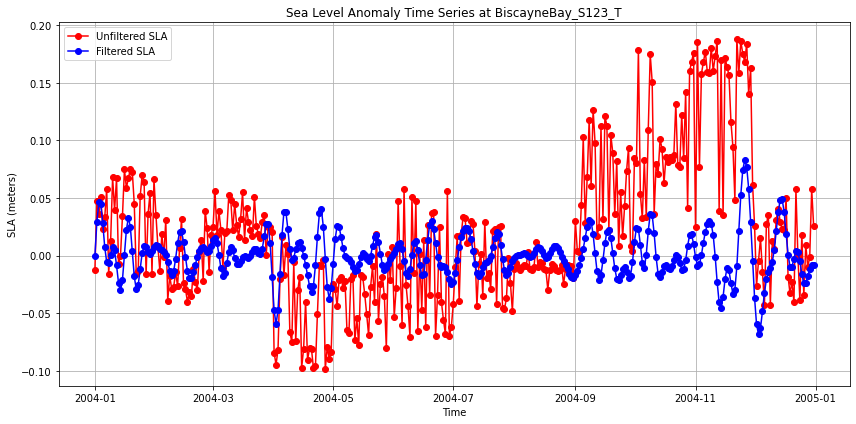

In [29]:
import os
import numpy as np
from scipy.signal import butter, filtfilt
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt

# Define Butterworth bandpass filter functions
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data, axis=0)
    return y

def interpolate_nan(data):
    """Interpolate NaNs in the data."""
    nans, x = np.isnan(data), lambda z: z.nonzero()[0]
    data[nans] = np.interp(x(nans), x(~nans), data[~nans])
    return data

def find_nearest_non_nan(dataset, lat_idx, lon_idx):
    """Find the nearest non-NaN value in the dataset around the given indices."""
    max_radius = 5  # Define the maximum search radius
    for radius in range(1, max_radius + 1):
        for dlat in range(-radius, radius + 1):
            for dlon in range(-radius, radius + 1):
                if abs(dlat) == radius or abs(dlon) == radius:
                    new_lat_idx = lat_idx + dlat
                    new_lon_idx = lon_idx + dlon
                    if (0 <= new_lat_idx < dataset.dims['latitude']) and (0 <= new_lon_idx < dataset.dims['longitude']):
                        sla_data_point = dataset['sla'].isel(latitude=new_lat_idx, longitude=new_lon_idx).values.item()
                        if not np.isnan(sla_data_point):
                            return sla_data_point
    return np.nan

# Load the dataset for 2004
base_dir = '/DGFI8/H/work_marcello/giussani_machinelearning_data/SEALEVEL_GLO_PHY_L4_REP_OBSERVATIONS_008_047/2004'



# Initialize dictionaries to store unfiltered and filtered time series
unfiltered_sla_time_series = {}
filtered_sla_time_series = {}

# Frequency cutoffs in cycles per day
lowcut = 0.035
highcut = 0.15
fs = 1.0  # Sampling frequency in cycles per day

# Iterate through each location
for location, coords in locations.items():
    latitude = coords['latitude']
    longitude = coords['longitude']
    
    # Initialize an empty list to store sla data for the location
    sla_data = []
    
    # Iterate through each month directory (01 to 12)
    for month in range(1, 13):
        month_str = f"{month:02d}"  # Format month as two digits
        
        # Iterate through each day file in the month directory
        for file_name in os.listdir(os.path.join(base_dir, month_str)):
            if file_name.endswith('.nc'):
                file_path = os.path.join(base_dir, month_str, file_name)
                
                # Open the dataset for the current file
                dataset = xr.open_dataset(file_path)
                
                # Find nearest indices to the specified latitude and longitude
                lat_idx = abs(dataset.latitude - latitude).argmin()
                lon_idx = abs(dataset.longitude - longitude).argmin()
                
                # Extract sla at the specified point for the current file
                sla_data_point = dataset['sla'].isel(latitude=lat_idx, longitude=lon_idx).values.item()
                
                # Check if sla_data_point is NaN and find the nearest non-NaN value if necessary
                if np.isnan(sla_data_point):
                    sla_data_point = find_nearest_non_nan(dataset, lat_idx, lon_idx)                
                
                # Append sla data point to the list
                sla_data.append(sla_data_point)
                
                # Close the dataset
                dataset.close()
    
    # Convert the list to xarray DataArray with time dimension
    time_index = pd.date_range(start='2004-01-01', end='2004-12-31', freq='D')
    sla_time_series_da = xr.DataArray(sla_data, dims=['time'], coords={'time': time_index})
    
    # Store unfiltered series in dictionary
    unfiltered_sla_time_series[location] = sla_time_series_da.values
    
    # Apply the Butterworth bandpass filter to the time series
    series = sla_time_series_da.values
    nan_count = np.isnan(series).sum()  # Count NaNs
    
    # Apply filtering only if less than or equal to 90% NaNs
    if nan_count <= 0.9 * len(sla_time_series_da.time):
        if nan_count > 0:
            series = interpolate_nan(series)  # Interpolate NaNs
        filtered_series = butter_bandpass_filter(series, lowcut, highcut, fs, order=5)  # Apply filter
    else:
        print(f"Skipping location '{location}' due to excessive NaNs.")
        filtered_series = np.full_like(series, np.nan)  # Create NaN-filled array
    
    # Store filtered series in dictionary
    filtered_sla_time_series[location] = filtered_series

# Example plot of one location's unfiltered and filtered time series (e.g., 'Eden')
location = selected_locations[0]
plt.figure(figsize=(12, 6))
plt.plot(time_index, unfiltered_sla_time_series[location], marker='o', linestyle='-', color='r', label='Unfiltered SLA')
plt.plot(time_index, filtered_sla_time_series[location], marker='o', linestyle='-', color='b', label='Filtered SLA')
plt.title(f'Sea Level Anomaly Time Series at {location}')
plt.xlabel('Time')
plt.ylabel('SLA (meters)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# Extract ML GRIDS

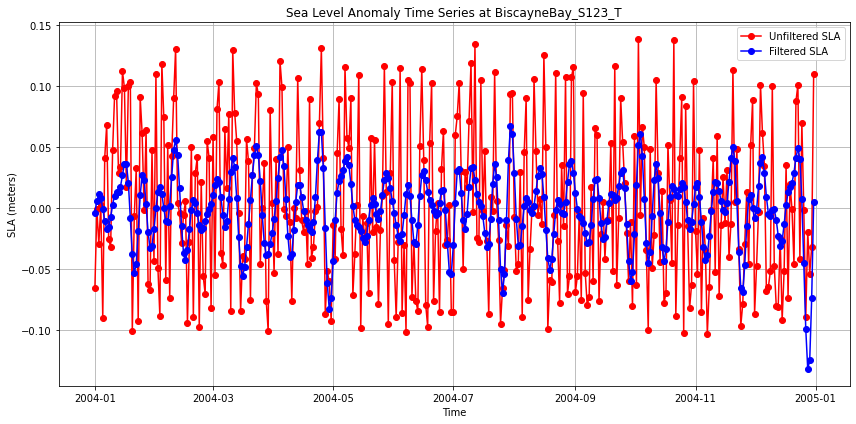

In [30]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import glob
import random
from scipy.signal import butter, filtfilt
import matplotlib.pyplot as plt

# Define Butterworth bandpass filter functions
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data, axis=0)
    return y

def interpolate_nan(data):
    """Interpolate NaNs in the data."""
    nans, x = np.isnan(data), lambda z: z.nonzero()[0]
    data[nans] = np.interp(x(nans), x(~nans), data[~nans])
    return data

# Define the path to the directory containing the files
base_dir = '/DGFI8/H/work_marcello/giussani_machinelearning_data/EAST_AUSTRALIA_ML_GRID_2004_COASTAL'


# Initialize dictionaries to store unfiltered and filtered time series
unfiltered_sla_ml_time_series = {}
filtered_sla_ml_time_series = {}

# Frequency cutoffs in cycles per day
lowcut = 0.035
highcut = 0.15
fs = 1.0  # Sampling frequency in cycles per day

# Get list of all CSV files
file_list = glob.glob(f'{base_dir}/EAST_AUSTRALIA_ML_GRID_2004_*')

# Iterate through each location
for location, coords in locations.items():
    latitude = coords['latitude']
    longitude = coords['longitude']
    
    # Initialize an empty list to store sla data for the location
    sla_data = []
    
    # Iterate through each file in the directory
    for file_path in file_list:
        # Read the CSV file into a pandas DataFrame
        df = pd.read_csv(file_path)
        
        # Convert the DataFrame to an xarray Dataset
        dataset = xr.Dataset.from_dataframe(df)
        
        # Find nearest indices to the specified latitude and longitude
        lat_idx = abs(dataset.lat - latitude).argmin().item()
        lon_idx = abs(dataset.lon - longitude).argmin().item()
        
        # Extract sla_predicted at the specified point for the current file
        sla_data_point = dataset['sla_predicted'].isel(index=lat_idx).values.item()
        
        # Append sla data point to the list
        sla_data.append(sla_data_point)
    
    # Convert the list to xarray DataArray with time dimension
    time_index = pd.date_range(start='2004-01-01', end='2004-12-31', freq='D')
    sla_time_series_da = xr.DataArray(sla_data, dims=['time'], coords={'time': time_index})
    
    # Store unfiltered series in dictionary
    unfiltered_sla_ml_time_series[location] = sla_time_series_da.values
    
    # Apply the Butterworth bandpass filter to the time series
    series = sla_time_series_da.values
    nan_count = np.isnan(series).sum()  # Count NaNs
    
    # Apply filtering only if less than or equal to 90% NaNs
    if nan_count <= 0.9 * len(sla_time_series_da.time):
        if nan_count > 0:
            series = interpolate_nan(series)  # Interpolate NaNs
        filtered_series = butter_bandpass_filter(series, lowcut, highcut, fs, order=5)  # Apply filter
    else:
        print(f"Skipping location '{location}' due to excessive NaNs.")
        filtered_series = np.full_like(series, np.nan)  # Create NaN-filled array
    
    # Store filtered series in dictionary
    filtered_sla_ml_time_series[location] = filtered_series

# Example plot of one location's unfiltered and filtered time series (e.g., 'Eden')
location = selected_locations[0]
plt.figure(figsize=(12, 6))
plt.plot(time_index, unfiltered_sla_ml_time_series[location], marker='o', linestyle='-', color='r', label='Unfiltered SLA')
plt.plot(time_index, filtered_sla_ml_time_series[location], marker='o', linestyle='-', color='b', label='Filtered SLA')
plt.title(f'Sea Level Anomaly Time Series at {location}')
plt.xlabel('Time')
plt.ylabel('SLA (meters)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


sla_time_series_da is an xarray DataArray containing sea level anomaly (SLA) time series data from tide gauges.
filtered_sla_time_series is a dictionary containing filtered sea level anomaly (SLA) time series data for the same locations from cmems. Please join the two in one single xarray DataArray

Shape of filtered_sla_array_cmems: (366, 12)
Shape of unfiltered_sla_array_cmems: (366, 12)
Shape of filtered_sla_array_ml: (366, 12)
Shape of unfiltered_sla_array_ml: (366, 12)


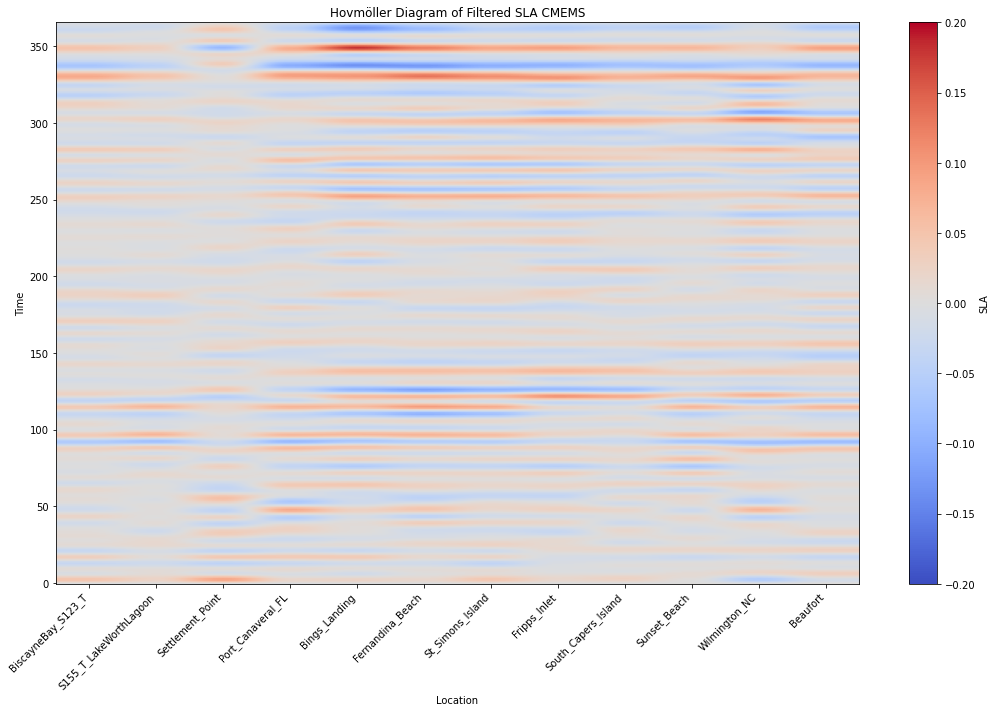

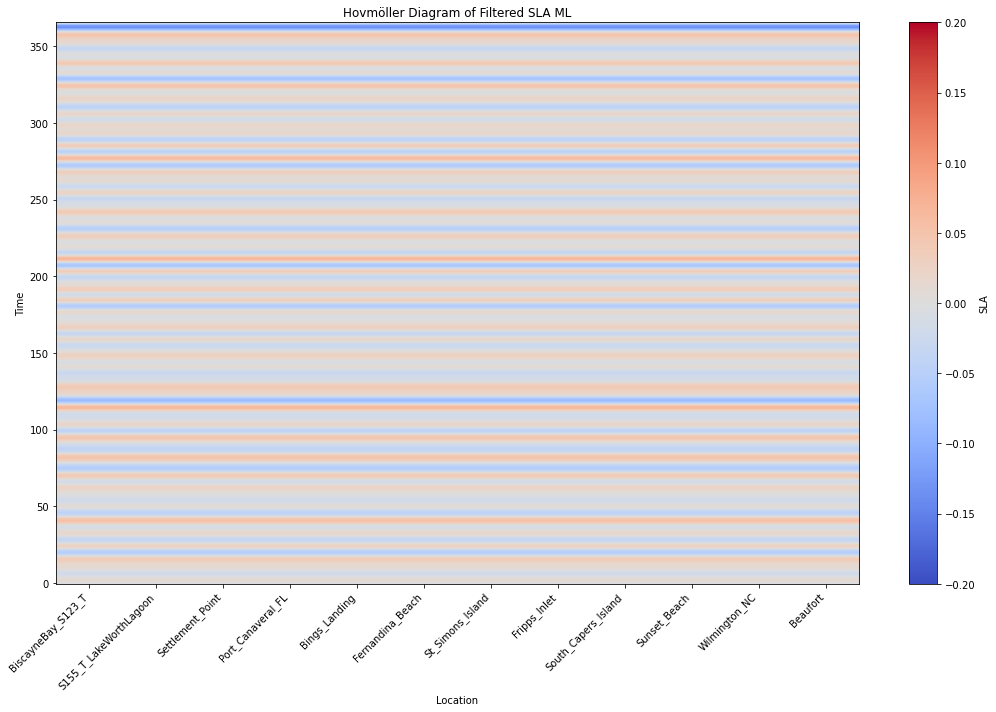

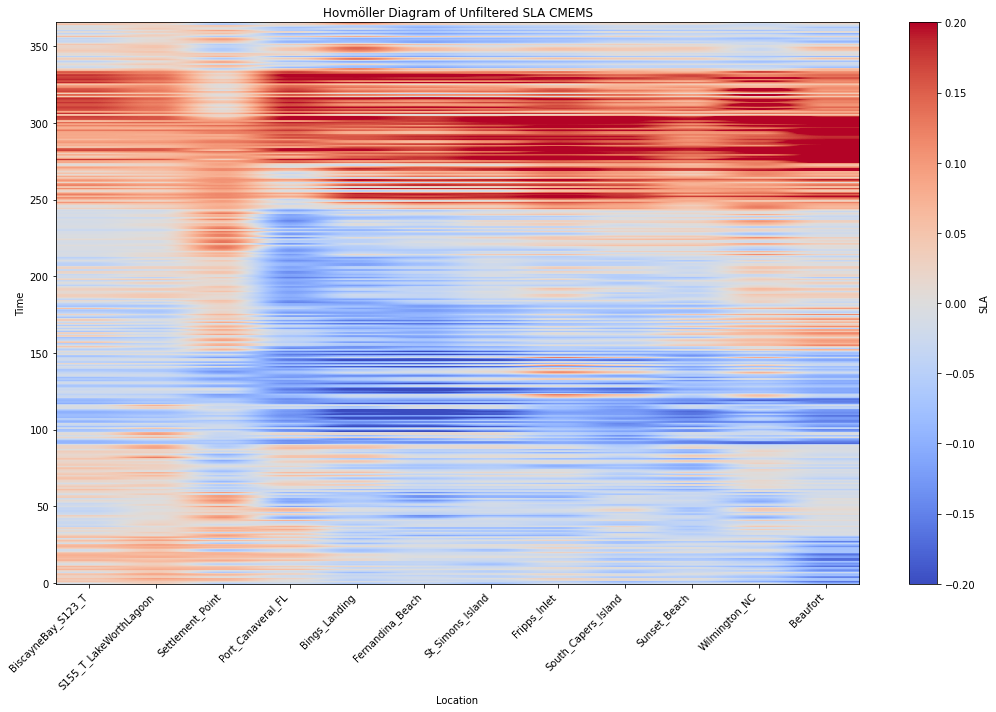

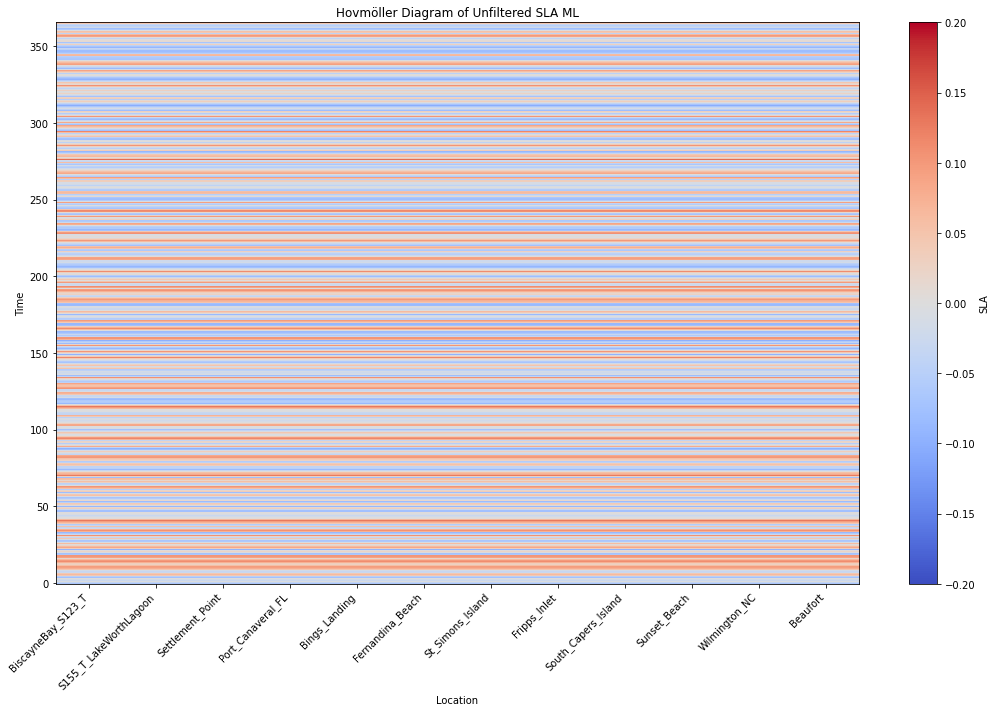

Latitude and Longitude for Selected Locations:
BiscayneBay_S123_T: Latitude 25.61055556, Longitude -80.3075
S155_T_LakeWorthLagoon: Latitude 26.64472222, Longitude -80.05472222
Settlement_Point: Latitude 26.69, Longitude -78.983
Port_Canaveral_FL: Latitude 28.415, Longitude -80.593
Bings_Landing: Latitude 29.615, Longitude -81.205
Fernandina_Beach: Latitude 30.672, Longitude -81.467
St_Simons_Island: Latitude 31.1317, Longitude -81.3967
Fripps_Inlet: Latitude 32.34, Longitude -80.465
South_Capers_Island: Latitude 32.8567, Longitude -79.7067
Sunset_Beach: Latitude 33.865, Longitude -78.5067
Wilmington_NC: Latitude 34.227, Longitude -77.953
Beaufort: Latitude 34.72, Longitude -76.67


In [31]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

# Assuming filtered_sla_time_series and unfiltered_sla_time_series are already defined as dictionaries
# Assuming filtered_sla_ml_time_series and unfiltered_sla_ml_time_series are already defined as dictionaries

# Extract time series and convert to numpy arrays for filtered CMEMS data
filtered_time_series_arrays_cmems = [filtered_sla_time_series[location] for location in filtered_sla_time_series]
filtered_sla_array_cmems = np.stack(filtered_time_series_arrays_cmems, axis=1)

# Extract time series and convert to numpy arrays for unfiltered CMEMS data
unfiltered_time_series_arrays_cmems = [unfiltered_sla_time_series[location] for location in unfiltered_sla_time_series]
unfiltered_sla_array_cmems = np.stack(unfiltered_time_series_arrays_cmems, axis=1)

# Extract time series and convert to numpy arrays for filtered ML data
filtered_time_series_arrays_ml = [filtered_sla_ml_time_series[location] for location in filtered_sla_ml_time_series]
filtered_sla_array_ml = np.stack(filtered_time_series_arrays_ml, axis=1)

# Extract time series and convert to numpy arrays for unfiltered ML data
unfiltered_time_series_arrays_ml = [unfiltered_sla_ml_time_series[location] for location in unfiltered_sla_ml_time_series]
unfiltered_sla_array_ml = np.stack(unfiltered_time_series_arrays_ml, axis=1)

# Verify the shape of the resulting arrays
print("Shape of filtered_sla_array_cmems:", filtered_sla_array_cmems.shape)
print("Shape of unfiltered_sla_array_cmems:", unfiltered_sla_array_cmems.shape)
print("Shape of filtered_sla_array_ml:", filtered_sla_array_ml.shape)
print("Shape of unfiltered_sla_array_ml:", unfiltered_sla_array_ml.shape)
# Expected output: (366, 14) if leap year, otherwise (365, 14)

# Define valid site names and coordinates for the x-axis labels
valid_site_names = list(filtered_sla_time_series.keys())
valid_latitudes = [locations[location]['latitude'] for location in valid_site_names]
valid_longitudes = [locations[location]['longitude'] for location in valid_site_names]

# Function to create Hovmöller diagram
def plot_hovmoller(data_array, title):
    fig, ax = plt.subplots(figsize=(15, 10))
    norm = Normalize(vmin=-0.2, vmax=0.2)
    im = ax.imshow(data_array, aspect='auto', cmap='coolwarm', origin='lower', norm=norm)
    ax.set_xlabel('Location')
    ax.set_ylabel('Time')
    ax.set_title(title)
    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label('SLA')
    ax.set_xticks(np.arange(len(valid_site_names)))
    ax.set_xticklabels(valid_site_names, rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

# Plot Hovmöller diagrams for filtered CMEMS and ML data
plot_hovmoller(filtered_sla_array_cmems, 'Hovmöller Diagram of Filtered SLA CMEMS')
plot_hovmoller(filtered_sla_array_ml, 'Hovmöller Diagram of Filtered SLA ML')

# Plot Hovmöller diagrams for unfiltered CMEMS and ML data
plot_hovmoller(unfiltered_sla_array_cmems, 'Hovmöller Diagram of Unfiltered SLA CMEMS')
plot_hovmoller(unfiltered_sla_array_ml, 'Hovmöller Diagram of Unfiltered SLA ML')

# Print latitude and longitude for each selected location
print("Latitude and Longitude for Selected Locations:")
for name, lat, lon in zip(valid_site_names, valid_latitudes, valid_longitudes):
    print(f"{name}: Latitude {lat}, Longitude {lon}")


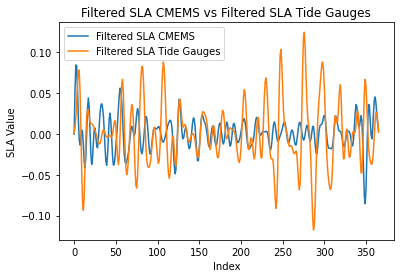

Correlation: -0.10256597320434306


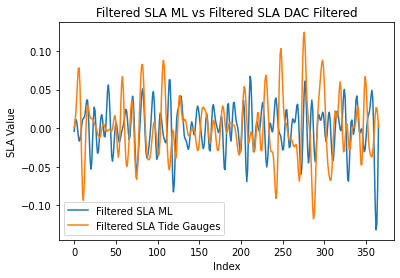

Correlation: 0.054670030219784754


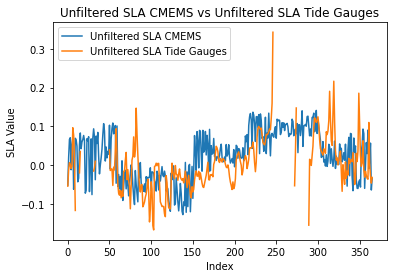

Correlation: 0.6143628263837103


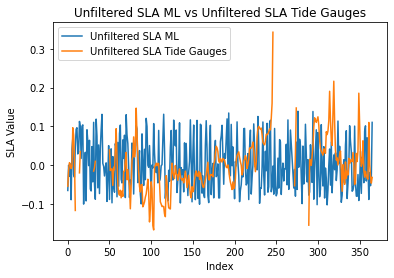

Correlation: 0.00829948442139547


In [32]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming these arrays are already defined and loaded
# filtered_sla_array_cmems, filtered_sla_dac_filtered, filtered_sla_array_ml, 
# unfiltered_sla_array_cmems, filtered_sla_dac_demeaned, unfiltered_sla_array_ml

plt.figure()
plt.plot(filtered_sla_array_cmems[:, 2], label='Filtered SLA CMEMS')
plt.plot(filtered_sla_dac_filtered[:, 2], label='Filtered SLA Tide Gauges')
plt.legend()
plt.xlabel('Index')
plt.ylabel('SLA Value')
plt.title('Filtered SLA CMEMS vs Filtered SLA Tide Gauges')
plt.show()
print("Correlation:", np.corrcoef(filtered_sla_array_cmems[:, 1], filtered_sla_dac_filtered[:, 1])[0, 1])

plt.figure()
plt.plot(filtered_sla_array_ml[:, 2], label='Filtered SLA ML')
plt.plot(filtered_sla_dac_filtered[:, 2], label='Filtered SLA Tide Gauges')
plt.legend()
plt.xlabel('Index')
plt.ylabel('SLA Value')
plt.title('Filtered SLA ML vs Filtered SLA DAC Filtered')
plt.show()
print("Correlation:", np.corrcoef(filtered_sla_array_ml[:, 1], filtered_sla_dac_filtered[:, 1])[0, 1])

plt.figure()
plt.plot(unfiltered_sla_array_cmems[:, 2], label='Unfiltered SLA CMEMS')
plt.plot(filtered_sla_dac_demeaned[:, 2], label='Unfiltered SLA Tide Gauges')
plt.legend()
plt.xlabel('Index')
plt.ylabel('SLA Value')
plt.title('Unfiltered SLA CMEMS vs Unfiltered SLA Tide Gauges')
plt.show()
print("Correlation:", np.corrcoef(unfiltered_sla_array_cmems[:, 1], filtered_sla_dac_demeaned[:, 1])[0, 1])

plt.figure()
plt.plot(unfiltered_sla_array_ml[:, 2], label='Unfiltered SLA ML')
plt.plot(filtered_sla_dac_demeaned[:, 2], label='Unfiltered SLA Tide Gauges')
plt.legend()
plt.xlabel('Index')
plt.ylabel('SLA Value')
plt.title('Unfiltered SLA ML vs Unfiltered SLA Tide Gauges')
plt.show()
print("Correlation:", np.corrcoef(unfiltered_sla_array_ml[:, 1], filtered_sla_dac_demeaned[:, 1])[0, 1])


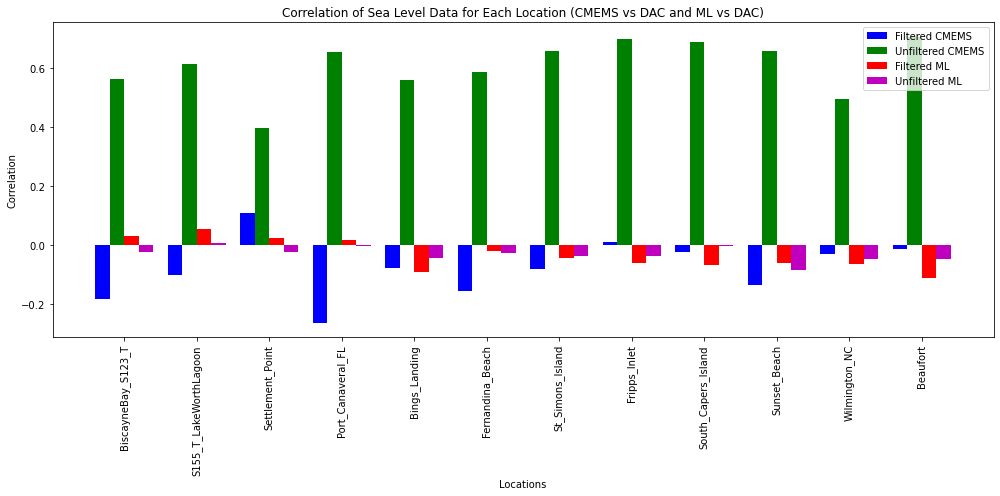

In [33]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming filtered_sla_array_cmems, filtered_sla_dac_filtered, unfiltered_sla_array_cmems,
# filtered_sla_dac_demeaned, filtered_sla_array_ml, and unfiltered_sla_array_ml are already defined

# Locations
locations = selected_locations

# Calculate correlation for filtered CMEMS data
filtered_correlations_cmems = []
for i in range(filtered_sla_array_cmems.shape[1]):
    corr = np.corrcoef(filtered_sla_array_cmems[:, i], filtered_sla_dac_filtered[:, i])[0, 1]
    filtered_correlations_cmems.append(corr)

# Calculate correlation for unfiltered CMEMS data
unfiltered_correlations_cmems = []
for i in range(unfiltered_sla_array_cmems.shape[1]):
    # Handle NaNs in unfiltered_sla_array_cmems and filtered_sla_dac_demeaned
    valid_indices = ~np.isnan(unfiltered_sla_array_cmems[:, i]) & ~np.isnan(filtered_sla_dac_demeaned[:, i])
    if np.any(valid_indices):
        corr = np.corrcoef(unfiltered_sla_array_cmems[valid_indices, i], filtered_sla_dac_demeaned[valid_indices, i])[0, 1]
    else:
        corr = np.nan  # If no valid data points, correlation is NaN
    unfiltered_correlations_cmems.append(corr)

# Calculate correlation for filtered ML data
filtered_correlations_ml = []
for i in range(filtered_sla_array_ml.shape[1]):
    corr = np.corrcoef(filtered_sla_array_ml[:, i], filtered_sla_dac_filtered[:, i])[0, 1]
    filtered_correlations_ml.append(corr)

# Calculate correlation for unfiltered ML data
unfiltered_correlations_ml = []
for i in range(unfiltered_sla_array_ml.shape[1]):
    # Handle NaNs in unfiltered_sla_array_ml and filtered_sla_dac_demeaned
    valid_indices = ~np.isnan(unfiltered_sla_array_ml[:, i]) & ~np.isnan(filtered_sla_dac_demeaned[:, i])
    if np.any(valid_indices):
        corr = np.corrcoef(unfiltered_sla_array_ml[valid_indices, i], filtered_sla_dac_demeaned[valid_indices, i])[0, 1]
    else:
        corr = np.nan  # If no valid data points, correlation is NaN
    unfiltered_correlations_ml.append(corr)

# Plotting
plt.figure(figsize=(14, 7))
bar_width = 0.2
index = np.arange(len(locations))

# Plot filtered CMEMS correlations
plt.bar(index, filtered_correlations_cmems, width=bar_width, label='Filtered CMEMS', color='b')

# Plot unfiltered CMEMS correlations
plt.bar(index + bar_width, unfiltered_correlations_cmems, width=bar_width, label='Unfiltered CMEMS', color='g')

# Plot filtered ML correlations
plt.bar(index + 2 * bar_width, filtered_correlations_ml, width=bar_width, label='Filtered ML', color='r')

# Plot unfiltered ML correlations
plt.bar(index + 3 * bar_width, unfiltered_correlations_ml, width=bar_width, label='Unfiltered ML', color='m')

plt.xticks(index + 1.5 * bar_width, locations, rotation=90)
plt.title('Correlation of Sea Level Data for Each Location (CMEMS vs DAC and ML vs DAC)')
plt.xlabel('Locations')
plt.ylabel('Correlation')
plt.legend()
plt.tight_layout()
plt.show()


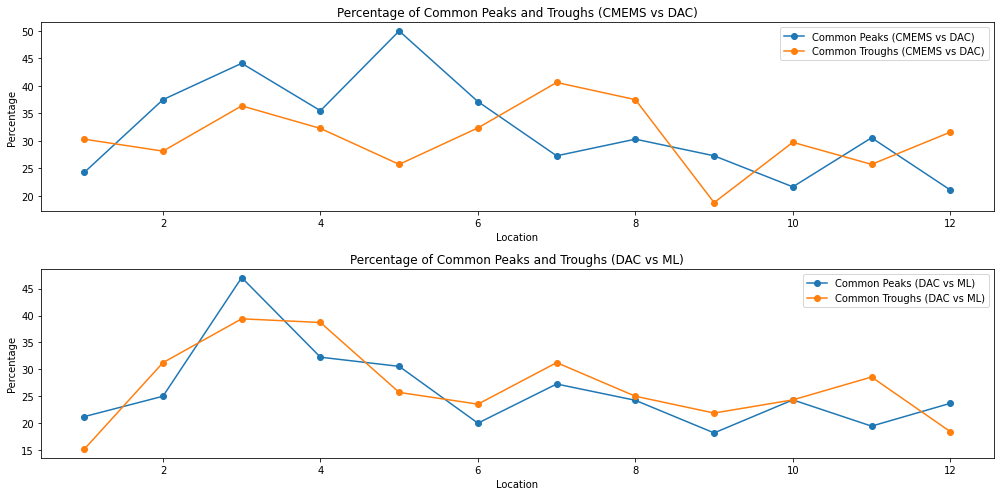

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks



# Function to find peaks and troughs
def find_peaks_troughs(data):
    peaks, _ = find_peaks(data)
    troughs, _ = find_peaks(-data)
    return peaks, troughs

# Find peaks and troughs for all datasets
def find_all_peaks_troughs(datasets):
    peaks = []
    troughs = []
    for data in datasets:
        peaks_loc = []
        troughs_loc = []
        for i in range(data.shape[1]):
            p, t = find_peaks_troughs(data[:, i])
            peaks_loc.append(p)
            troughs_loc.append(t)
        peaks.append(peaks_loc)
        troughs.append(troughs_loc)
    return peaks, troughs

datasets = [filtered_sla_array_cmems, filtered_sla_dac_filtered, filtered_sla_array_ml]
peaks, troughs = find_all_peaks_troughs(datasets)

peaks_cmems, peaks_dac, peaks_ml = peaks
troughs_cmems, troughs_dac, troughs_ml = troughs

# Function to compare peaks and troughs with a tolerance of 2 days
def compare_peaks_troughs_with_tolerance(peaks1, peaks2, troughs1, troughs2, tolerance=1):
    def within_tolerance(array1, array2):
        common = []
        for x in array1:
            if any(abs(x - y) <= tolerance for y in array2):
                common.append(x)
        return common

    peak_diff = []
    trough_diff = []
    
    for i in range(len(peaks1)):
        common_peaks = within_tolerance(peaks1[i], peaks2[i])
        common_troughs = within_tolerance(troughs1[i], troughs2[i])
        
        peak_diff.append(common_peaks)
        trough_diff.append(common_troughs)
    
    return peak_diff, trough_diff

# Compare peaks and troughs for both dataset pairs
peak_diff_cmems_dac, trough_diff_cmems_dac = compare_peaks_troughs_with_tolerance(peaks_cmems, peaks_dac, troughs_cmems, troughs_dac)
peak_diff_dac_ml, trough_diff_dac_ml = compare_peaks_troughs_with_tolerance(peaks_dac, peaks_ml, troughs_dac, troughs_ml)

# Calculate the percentage of common peaks and troughs compared to DAC for each location
def calculate_percentage(common, reference):
    percentage = []
    for i in range(len(common)):
        if len(reference[i]) == 0:
            percentage.append(0)
        else:
            percentage.append(len(common[i]) / len(reference[i]) * 100)
    return percentage

percentage_peaks_cmems_dac = calculate_percentage(peak_diff_cmems_dac, peaks_dac)
percentage_troughs_cmems_dac = calculate_percentage(trough_diff_cmems_dac, troughs_dac)
percentage_peaks_dac_ml = calculate_percentage(peak_diff_dac_ml, peaks_dac)
percentage_troughs_dac_ml = calculate_percentage(trough_diff_dac_ml, troughs_dac)

# Plot the percentages
locations = np.arange(1, len(percentage_peaks_cmems_dac) + 1)

plt.figure(figsize=(14, 7))

plt.subplot(2, 1, 1)
plt.plot(locations, percentage_peaks_cmems_dac, marker='o', label='Common Peaks (CMEMS vs DAC)')
plt.plot(locations, percentage_troughs_cmems_dac, marker='o', label='Common Troughs (CMEMS vs DAC)')
plt.xlabel('Location')
plt.ylabel('Percentage')
plt.title('Percentage of Common Peaks and Troughs (CMEMS vs DAC)')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(locations, percentage_peaks_dac_ml, marker='o', label='Common Peaks (DAC vs ML)')
plt.plot(locations, percentage_troughs_dac_ml, marker='o', label='Common Troughs (DAC vs ML)')
plt.xlabel('Location')
plt.ylabel('Percentage')
plt.title('Percentage of Common Peaks and Troughs (DAC vs ML)')
plt.legend()

plt.tight_layout()
plt.show()


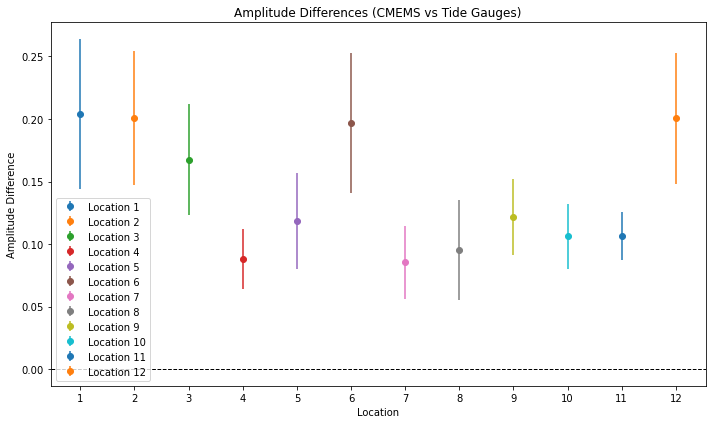

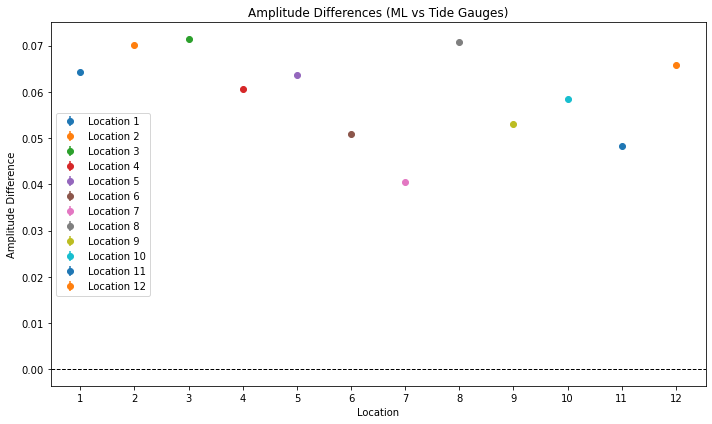

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# Function to find peaks and troughs
def find_peaks_troughs(data):
    peaks, _ = find_peaks(data)
    troughs, _ = find_peaks(-data)
    return peaks, troughs

# Find peaks and troughs for all datasets
def find_all_peaks_troughs(datasets):
    peaks = []
    troughs = []
    for data in datasets:
        peaks_loc = []
        troughs_loc = []
        for i in range(data.shape[1]):
            p, t = find_peaks_troughs(data[:, i])
            peaks_loc.append(p)
            troughs_loc.append(t)
        peaks.append(peaks_loc)
        troughs.append(troughs_loc)
    return peaks, troughs

# Function to compare peaks and troughs with a tolerance of 2 days
def compare_peaks_troughs_with_tolerance(peaks1, peaks2, troughs1, troughs2, tolerance=2):
    def within_tolerance(array1, array2):
        common = []
        for x in array1:
            if any(abs(x - y) <= tolerance for y in array2):
                common.append(x)
        return common

    peak_diff = []
    trough_diff = []
    
    min_len = min(len(peaks1), len(peaks2))
    
    for i in range(min_len):
        common_peaks = within_tolerance(peaks1[i], peaks2[i])
        common_troughs = within_tolerance(troughs1[i], troughs2[i])
        
        peak_diff.append(common_peaks)
        trough_diff.append(common_troughs)
    
    return peak_diff, trough_diff

# Calculate the amplitude differences for common peaks and troughs
def calculate_amplitude_differences(data, indices):
    amplitude_diffs = []
    for idx in indices:
        if len(idx) > 0:
            amplitudes = []
            for i in idx:
                amplitudes.append(data[i])
            ref_amplitude = np.max(amplitudes) - np.min(amplitudes)
            diffs = [ref_amplitude - (np.max(data[i]) - np.min(data[i])) for i in idx]
            amplitude_diffs.append(diffs)
        else:
            amplitude_diffs.append([])
    return amplitude_diffs

# Function to plot amplitude differences
def plot_amplitude_differences(amplitude_diffs, title):
    locations = np.arange(1, len(amplitude_diffs) + 1)
    plt.figure(figsize=(10, 6))
    
    for i, diffs in enumerate(amplitude_diffs):
        if len(diffs) > 0:
            plt.errorbar(locations[i], np.mean(diffs), yerr=np.std(diffs), fmt='o', label=f'Location {i+1}')
    
    plt.axhline(0, color='k', linestyle='--', linewidth=1)
    plt.xlabel('Location')
    plt.ylabel('Amplitude Difference')
    plt.title(title)
    plt.xticks(locations)
    plt.legend()
    plt.tight_layout()
    plt.show()


filtered_sla_tide_gauges = filtered_sla_dac_filtered
datasets = [filtered_sla_array_cmems, filtered_sla_tide_gauges, filtered_sla_array_ml]

# Find peaks and troughs for all datasets
peaks, troughs = find_all_peaks_troughs(datasets)

peaks_cmems, peaks_tide_gauges, peaks_ml = peaks
troughs_cmems, troughs_tide_gauges, troughs_ml = troughs

# Compare peaks and troughs for both dataset pairs
peak_diff_cmems_tide_gauges, trough_diff_cmems_tide_gauges = compare_peaks_troughs_with_tolerance(peaks_cmems, peaks_tide_gauges, troughs_cmems, troughs_tide_gauges)
peak_diff_tide_gauges_ml, trough_diff_tide_gauges_ml = compare_peaks_troughs_with_tolerance(peaks_tide_gauges, peaks_ml, troughs_tide_gauges, troughs_ml)

# Calculate amplitude differences for common peaks and troughs
amplitude_diffs_peaks_cmems_tide_gauges = calculate_amplitude_differences(filtered_sla_array_cmems, peak_diff_cmems_tide_gauges)
amplitude_diffs_troughs_cmems_tide_gauges = calculate_amplitude_differences(filtered_sla_array_cmems, trough_diff_cmems_tide_gauges)
amplitude_diffs_peaks_ml_tide_gauges = calculate_amplitude_differences(filtered_sla_array_ml, peak_diff_tide_gauges_ml)
amplitude_diffs_troughs_ml_tide_gauges = calculate_amplitude_differences(filtered_sla_array_ml, trough_diff_tide_gauges_ml)

# Plot amplitude differences with Tide Gauges as reference
plot_amplitude_differences(amplitude_diffs_peaks_cmems_tide_gauges, 'Amplitude Differences (CMEMS vs Tide Gauges)')
plot_amplitude_differences(amplitude_diffs_peaks_ml_tide_gauges, 'Amplitude Differences (ML vs Tide Gauges)')


Consider the following dataset and their shapes:
Shape of filtered_sla_array_cmems: (366, 14)
Shape of filtered_sla_array_ml: (366, 14)
Shape of filtered_sla_dac_filtered: (366, 14)

Each correspond to sea level time series at 14 different locations at a daily rate for the year 2004, obtained by three different dataset. The dataset filtered_sla_dac_filtered shall be called "Tide gauges" in the plots. Compute the time lagged correlation between the first and the last location (coloumn) of each dataset and plot it in a plot with correlation coefficient in the y-axis and time-lag from 1 to 15 days in the x-axis.

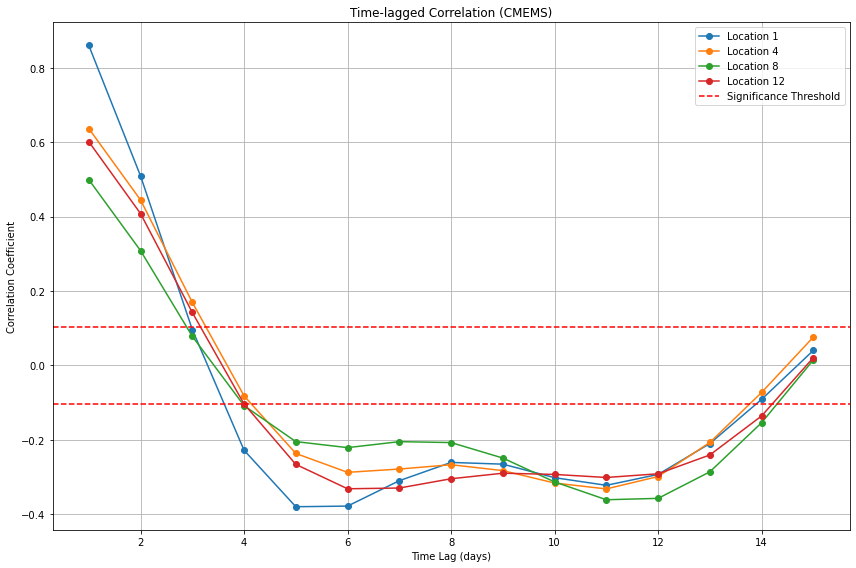

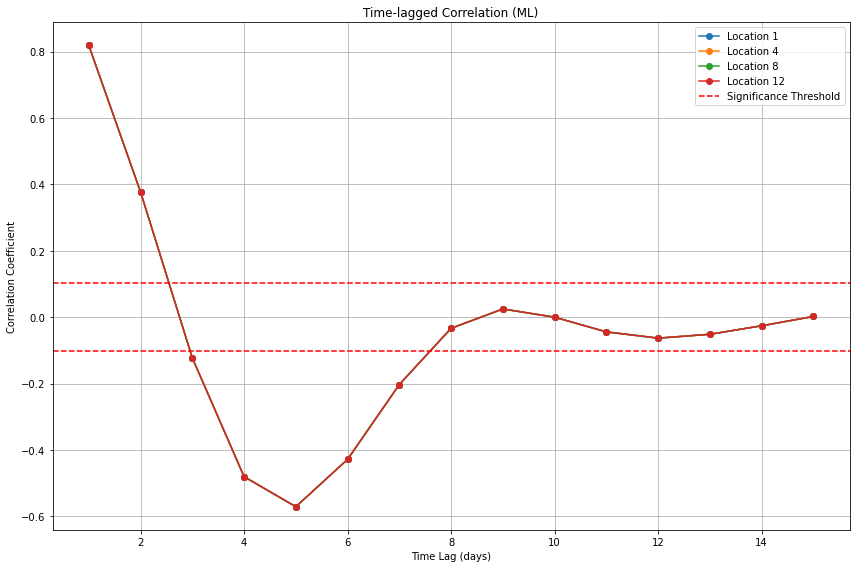

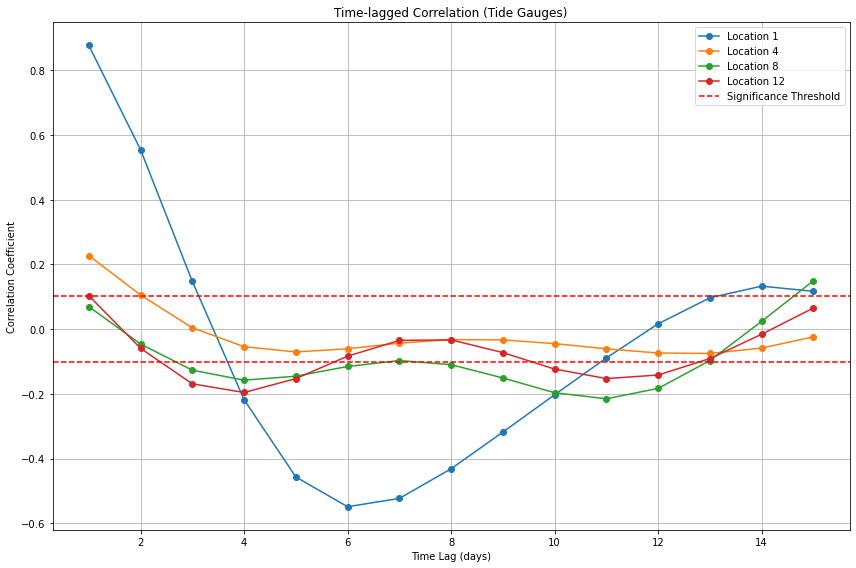

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import t


# Function to compute time-lagged correlation
def time_lagged_correlation(data, max_lag=15):
    num_locations = data.shape[1]
    correlations = np.zeros((num_locations, max_lag))
    for loc in range(num_locations):
        for lag in range(1, max_lag + 1):
            correlation = np.corrcoef(data[:-lag, 0], data[lag:, loc])[0, 1]
            correlations[loc, lag-1] = correlation
    return correlations

# Function to select up to 4 equally spaced locations
def select_locations(num_locations):
    indices = np.linspace(0, num_locations - 1, min(4, num_locations), dtype=int)
    return indices

# Function to compute the significance threshold for correlation coefficients
def compute_significance_threshold(n, alpha=0.05):
    df = n - 2  # degrees of freedom
    t_critical = t.ppf(1 - alpha/2, df)
    r_threshold = np.sqrt(t_critical**2 / (t_critical**2 + df))
    return r_threshold

# Plotting function for each dataset
def plot_time_lagged_correlations(correlations, title, n, alpha=0.05):
    lags = np.arange(1, correlations.shape[1] + 1)
    selected_indices = select_locations(correlations.shape[0])
    r_threshold = compute_significance_threshold(n, alpha)

    plt.figure(figsize=(12, 8))
    for loc in selected_indices:
        plt.plot(lags, correlations[loc], marker='o', label=f'Location {loc+1}')
    
    plt.axhline(y=r_threshold, color='r', linestyle='--', label='Significance Threshold')
    plt.axhline(y=-r_threshold, color='r', linestyle='--')
    plt.xlabel('Time Lag (days)')
    plt.ylabel('Correlation Coefficient')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Compute time-lagged correlations for each dataset
max_lag = 15
n = 366  # number of samples
corr_cmems = time_lagged_correlation(filtered_sla_array_cmems, max_lag)
corr_ml = time_lagged_correlation(filtered_sla_array_ml, max_lag)
corr_tide_gauges = time_lagged_correlation(filtered_sla_dac_filtered, max_lag)

# Plot the time-lagged correlations for each dataset
plot_time_lagged_correlations(corr_cmems, 'Time-lagged Correlation (CMEMS)', n)
plot_time_lagged_correlations(corr_ml, 'Time-lagged Correlation (ML)', n)
plot_time_lagged_correlations(corr_tide_gauges, 'Time-lagged Correlation (Tide Gauges)', n)
